In [1]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper

from utils import make_env


num_stack = 4
skipframe_div = 10

env = make_env(num_stack=num_stack*skipframe_div, skipframe_div=skipframe_div)
env = GymWrapper(env)
tf_env = TFPyEnvironment(env)

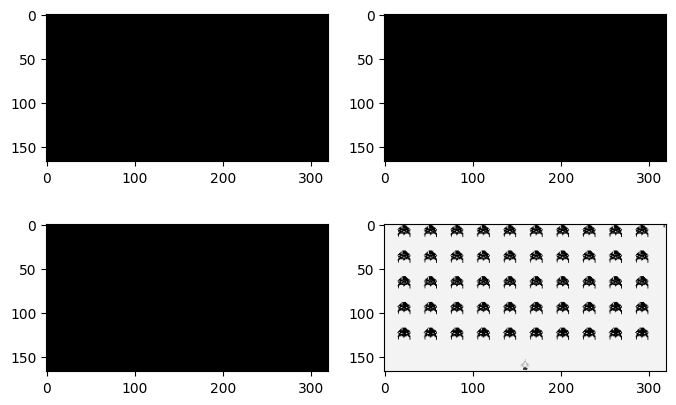

In [2]:
from matplotlib import pyplot as plt


obs = tf_env.reset()

# action = tf_env.action_space.sample()
obs = tf_env.step(3)[3]

plt.figure(figsize=(8, 5))
for i in range(1, num_stack+1):
    plt.subplot(2, 2, i)
    plt.imshow(obs[0, ..., i-1], cmap="gray")

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

from tf_agents.networks.q_network import QNetwork


preprocessing_layer = layers.Lambda(lambda obs: tf.cast(obs, tf.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 2), (128, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

In [4]:
train_iters = 50_000
buffer_size = 100_000
update_period = 10 # run a training step every 10 collect steps

In [5]:
from tensorflow.keras import optimizers, losses

from tf_agents.agents.dqn.dqn_agent import DqnAgent


train_step = tf.Variable(0)

optimizer = optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
                                     
epsilon_fn = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=train_iters,
    end_learning_rate=0.01
)

agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=5_000,
    td_errors_loss_fn=losses.Huber(reduction="none"),
    gamma=0.90, # discount factor
    train_step_counter=train_step,
    epsilon_greedy=lambda: epsilon_fn(train_step)
)

agent.initialize()

In [6]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer


replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=buffer_size//2
)
replay_buffer_observer = replay_buffer.add_batch

dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3
).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [7]:
from tf_agents.metrics import tf_metrics
from tf_agents.eval.metric_utils import log_metrics

import logging


class ShowProgress:

    def __init__(self, total):
        self.counter = 0
        self.total = total
        
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")
            

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [8]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver


collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [9]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy


initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(buffer_size//2)],
    num_steps=buffer_size//2
)

final_time_step, final_policy_state = init_driver.run()

50000/50000

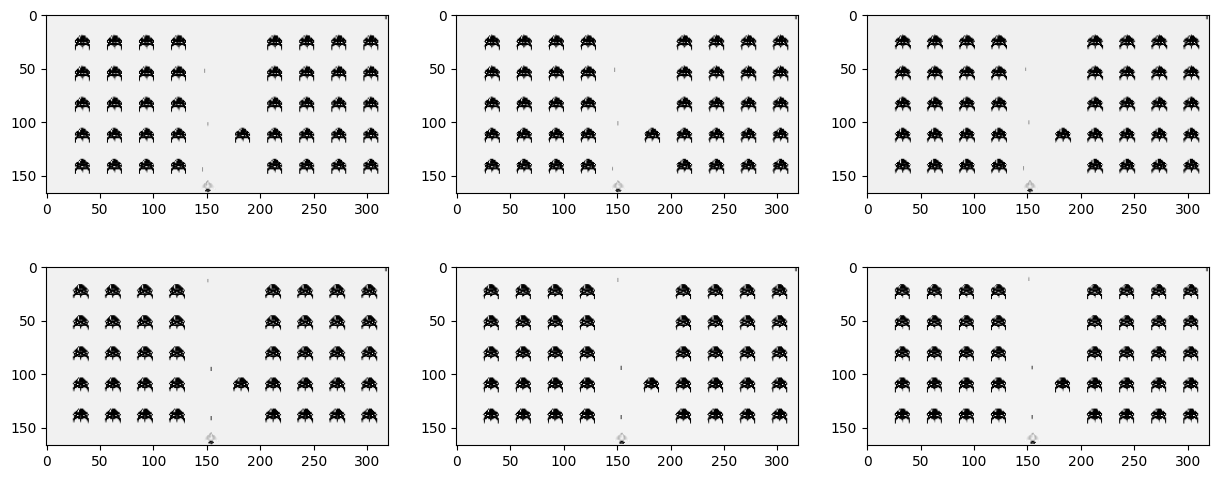

In [10]:
from tf_agents.trajectories.trajectory import to_transition


trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False
)))

plt.figure(figsize=(15, 6))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plt.imshow(trajectories.observation[row, col, ..., -1].numpy(), cmap="gray")
plt.show()

In [11]:
from tf_agents.utils.common import function


collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [12]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)

    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)

        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")

        if iteration % (n_iterations//10) == 0:
            log_metrics(train_metrics)

    log_metrics(train_metrics)
    tf.saved_model.save(agent._q_network, f"models/Alien Invasion DQN TF-Agents ({n_iterations} iters)")

In [13]:
train_agent(n_iterations=train_iters)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 10
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


4998 loss:0.068551

INFO:absl: 
		 NumberOfEpisodes = 7
		 EnvironmentSteps = 50010
		 AverageReturn = -1627.04296875
		 AverageEpisodeLength = 6502.71435546875


9998 loss:0.289916

INFO:absl: 
		 NumberOfEpisodes = 15
		 EnvironmentSteps = 100010
		 AverageReturn = -1662.73046875
		 AverageEpisodeLength = 6770.2001953125


14999 loss:0.077700

INFO:absl: 
		 NumberOfEpisodes = 22
		 EnvironmentSteps = 150010
		 AverageReturn = -1638.0111083984375
		 AverageEpisodeLength = 6872.39990234375


19999 loss:0.003509

INFO:absl: 
		 NumberOfEpisodes = 30
		 EnvironmentSteps = 200010
		 AverageReturn = -1602.2398681640625
		 AverageEpisodeLength = 6581.0


24999 loss:0.072684

INFO:absl: 
		 NumberOfEpisodes = 37
		 EnvironmentSteps = 250010
		 AverageReturn = -1594.215087890625
		 AverageEpisodeLength = 6815.10009765625


29999 loss:0.540686

INFO:absl: 
		 NumberOfEpisodes = 44
		 EnvironmentSteps = 300010
		 AverageReturn = -1557.3046875
		 AverageEpisodeLength = 6567.2001953125


34999 loss:9.613796

INFO:absl: 
		 NumberOfEpisodes = 52
		 EnvironmentSteps = 350010
		 AverageReturn = -1506.52734375
		 AverageEpisodeLength = 6726.39990234375


39999 loss:0.180144

INFO:absl: 
		 NumberOfEpisodes = 59
		 EnvironmentSteps = 400010
		 AverageReturn = -1503.6634521484375
		 AverageEpisodeLength = 6720.5


44998 loss:0.220857

INFO:absl: 
		 NumberOfEpisodes = 66
		 EnvironmentSteps = 450010
		 AverageReturn = -1453.5244140625
		 AverageEpisodeLength = 6828.39990234375


49998 loss:0.197929

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 500000
		 AverageReturn = -1395.8763427734375
		 AverageEpisodeLength = 7386.2998046875


49999 loss:0.21824INFO:tensorflow:Assets written to: models/Alien Invasion DQN TF-Agents (50000 iters)\assets


INFO:tensorflow:Assets written to: models/Alien Invasion DQN TF-Agents (50000 iters)\assets


In [14]:
frames = []

tf_env.pyenv.envs[0].reset()

def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render())

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(10_000)],
    num_steps=10_000)
final_time_step, final_policy_state = watch_driver.run()

10000/10000

In [15]:
import PIL

import os


image_path = os.path.join("rl videos", "alieninvasion_tfagents_50000.gif")

frame_images = []
for frame in frames:
    frame.shape = frame.shape[:-1]
    frame_images.append(PIL.Image.fromarray(frame))

frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [16]:
# agent._q_network = tf.saved_model.load("models/Alien Invasion DQN TF-Agents (50_000 iters)")